### gpu_vs_cpu.ipynb

The purpose of this notebook is to explore the performance and usability of computations on the CPU vs. on the GPU, using PyTorch

## Motivation

In class, we spent some time discussing AlexNet. We mentioned that it was able to be larger because it utilized GPUs, which was novel at the time. This allowed for more computations and thus more learning to be done over a massive dataset. We also mentioned that due to the memory constraints of the GPUs, the convolutional neural network (CNN) needed to be broken down into two seperate pieces, rather than one large piece. Thus, the purpose of this notebook is to explore using the GPU for calculations on PyTorch. I don't remember where I saw this, but PyTorch as a package provides three key features or functionalities:

1. Neural Network and Deep Learning Model Architectures
2. Automatic Differentiation, and associated Optimization Methods
3. Tensor Datatypes with efficient Computation, through use of GPUs

My past notebooks have focused more on the second, and a little on the first functionalities. I've almost completely ignored efficient computation using GPUs. The purpose of this notebook is to begin down that path.

## Exploration

This section will focus on exploration, without too much structure or rigor. This is mainly to learn the fundamentals of PyTorch, without necessarily getting any helpful or noteable results. I'll be refering to a few different tutorials, but writing my own code and deciding how to combine them. I'll start with [PyTorch's Documentation](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html?highlight=gpu). I'll also use another resource from [Weights & Biases](https://wandb.ai/wandb/common-ml-errors/reports/How-To-Use-GPU-with-PyTorch---VmlldzozMzAxMDk).

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Device: {device}')
print(f'Type of \'device\': {type(device)} ')

n_devices = torch.cuda.device_count()

print(f'Number of devices: {n_devices}')
print(f'Current device: {torch.cuda.current_device()}')

for i in range(n_devices):
    print(f'Device {i} : {torch.cuda.get_device_name(0)}')

Device: cuda
Type of 'device': <class 'torch.device'> 
Number of devices: 1
Current device: 0
Device 0 : NVIDIA GeForce GTX 1050


GPU found. Great!

We also show a few other functions for checking and looking at devices. The `device` object is more than just a string or an integer. We see that I have one GPU. For larger problems, we may have multiple GPUs, and we may need to send objects between them (like in the original AlexNet). This code will be helpful for later in the semester when I hope to run PyTorch on CU's [Alpine Supercomputing system](https://curc.readthedocs.io/en/latest/clusters/alpine/index.html) (which has some fancy GPUs).

Well actually, at the time of first writing this, the GPU was found. However, on the same machine, I later had problems with the GPU not being found. I could not find a GPU, despite restarting my editor, trying via command line, checking Task Manager for other programs using the GPU, and opening NVIDIAs Control Panel. I saw a few system tasks in Task Manager that were sporadically using the GPU, but only a small capacity of it. Still, I thought that these tasks could be temporarily stealing the GPU. With this thinking in mind, I wrote a short for loop that checked for the GPU, paused 200 milliseconds, and checked again. Running this a few times, the GPU was never found. However, on one run, my computer blue-screened, and I had a `Driver_State_Failure`, or something of that nature. My computer has been having problems already, so this is likely related. However, this whole experience goes to show that this apparently simple check can sometimes fail (and be a huge headache). I've found that restarting my computer is the easiest way to deal with this issue of not finding the GPU.

In [2]:
x_gpu = torch.ones(5,device=device)
x_cpu = torch.ones(5)
print('Initialization Method:')
print(x_gpu)
print(x_cpu)
print('.to Method:')
x_gpu2 = x_cpu.to(device)
print(x_gpu2)
# Make sure that this was not modified
print(x_cpu)
print('.cuda and .cpu Methods:')
x_gpu3 = x_cpu.cuda()
x_cpu2 = x_gpu.cpu()
print(x_gpu3)
print(x_cpu2)
# Make sure that these were not modified
print(x_gpu)
print(x_cpu)
# Check that calling without an output does not modify either
x_gpu.cpu()
print(x_gpu)

# Check one last way.
x_gpu4 = torch.zeros_like(x_cpu,device=device)
x_gpu4.copy_(x_cpu)
print('.copy_ Method:')
print(x_gpu4)
print(x_cpu)

print(x_cpu.is_cuda)
print(x_gpu.is_cuda)

Initialization Method:
tensor([1., 1., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1.])
.to Method:
tensor([1., 1., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1.])
.cuda and .cpu Methods:
tensor([1., 1., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1.], device='cuda:0')
.copy_ Method:
tensor([1., 1., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1.])
False
True


Above are a few different ways to put/move things between devices:
1. `device=device` during initialization, and using `_copy`
2. `to(device)` and assign the output to a different variable
3. `cpu()` and `gpu()`

And the `is_cuda` property tells us if the object is on the GPU (`True`) or the CPU (`False`).

When my computer could not find a GPU, this block gave errors. This is because calling `gpu()` had no GPU to move the object to. Thus, it's best to just use the `to(device)`, and maybe the `cpu()` functions, and to avoid using `gpu()`, in case the GPU is not found.

In [3]:
try:
    print(x_cpu + x_gpu)
except:
    print('Error because we are trying to do computations between CPU and GPU')

y_gpu = x_gpu+x_gpu2
print(y_gpu)

Error because we are trying to do computations between CPU and GPU
tensor([2., 2., 2., 2., 2.], device='cuda:0')


In the above, we see that we cannot have objects "interact" if they are on separate devices. We are only testing with tensors so far, but we'll assume that models and other objects also follow these same general rules. We would either need to move the GPU objects to the CPU and use the CPU as usual, or move the CPU objects to the GPU and do our computations there.

AlexNet needed to use two GPUs and communicate between them because the memory of these GPUs was limited. Inspired by this, let's see if we can find out the memory of my GPU.

In [4]:
device.__sizeof__()
# print(torch.cuda.memory_allocated()) # This returns the current memory allocated in bytes.
# print(torch.cuda.memory_stats()) # This isn't readable.
print(torch.cuda.max_memory_reserved())
print(torch.cuda.memory_summary())

2097152
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    2560 B  |    5632 B  |  106496 B  |  103936 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |    2560 B  |    5632 B  |  106496 B  |  103936 B  |
|---------------------------------------------------------------------------|
| Active memory         |    2560 B  |    5632 B  |  106496 B  |  103936 B  |
|       from large pool |       0 B  |       0 B  |     

In the above, we see quite a bit of information. I won't get into everything, but we see that I have a total allocation of 682496 Bytes, or 0.000682496 Gigabytes. According to [NVIDIA's specifications](https://www.nvidia.com/en-gb/geforce/graphics-cards/geforce-gtx-1050/specifications/), my GPU has "640 CUDA Cores" and "2 GB GDDR5". The other `max_memory_reserved` is 0.002 Gigabytes. Multiplying this by 640, we get 1.34 Gigabytes, which is close enough to the stated 2 GB memory, but I'm not totally sure if just multiplying these makes sense. That would imply that `max_memory_reserved` returns the memory reserved for each core, which is unusual, as we often think of memory and cores separately.

I was familiar with the idea that GPUs are given, and then follow a set of instructions for many iterations, so the high number of Cores made some sense to me. GPUs have many different cores so that a task can be broken down into somewhat small sets of instructions, to make these instruction able to be repeated. It's the repeating the instructions that makes the GPU efficient. I was also curious why they are specified as "Cuda Cores", and not just "Cores". It turns out that there are other types of GPU cores, with the "Tensor Cores" being most applicable to Machine Learning computations (Nvidia also has GPUs with "Ray-Tracing Cores"). From this [website](https://www.techcenturion.com/nvidia-cuda-cores/), the main differences between CUDA and Tensor cores are explained:

> CUDA cores have been present on every single GPU developed by Nvidia in the past decade while Tensor Cores have recently been introduced.
> 
> Tensor cores can compute a lot faster than the CUDA cores. CUDA cores perform one operation per clock cycle, whereas tensor cores can perform multiple operations per clock cycle.
> 
> Everything comes with a cost, and here, the cost is accuracy. Accuracy takes a hit to boost the computation speed. On the other hand, CUDA cores produce very accurate results.
> 
> For machine learning models, CUDA cores are not as effective as Tensor cores in terms of both cost and computation speed. Hence, these are the preferred choice for training machine learning models.
>  

Anyways, I'm not able to fully explain all of the memory details, but that is only a problem if I run out of memory.

## CPU vs. GPU timing

How much does using a GPU impact training time? There are lots of added difficulties when working with a GPU, so hopefully this is justified by a substantial speed up.

To test timing, I'll create just a simple example problem and run it with tensors on the CPU vs on the GPU. In machine learning, we use a number of different functions, such as pooling, convolution, activation functions, and linear transformations. The most common and versatile of these a linear transformation. Thus, I'll look at the run times associated with doing linear transformations.

### Example Problem
Let $A \in \mathbb{R}^{n \times n}$, $x \in \mathbb{R}^{n \times 1}$. Then, $A x:=b \in \mathbb{R}^{n \times 1}$. Because we are investigating this in a general sense, we will randomly generate $A$ and $x$ and then time the computation of $b$. We will write a function to do all the computations and record the run time, then we will use this function for both the CPU and GPU. Although there's some difference between the accuracies depending on the device (mentioned in one of the previous links), we will not look into this.

In [22]:
import time
import numpy as np

def test_function(n,device):
    A = torch.rand((n,n),device=device)
    x = torch.rand((n),device=device)
    b = torch.matmul(A,x)

def repeat_runs_and_time(n,device):
    t_s = time.perf_counter()
    for i in range(10):
        test_function(n,device)
    t_f = time.perf_counter()
    return (t_f-t_s)

def do_many_runs(ns,device=None):
    if device==None:
        device = torch.device('cpu')

    N_ns = len(ns)
    times = torch.zeros(N_ns)
    for i,n in enumerate(ns):
        times[i] = repeat_runs_and_time(n,device)

    return times

# Generate a bunch of different sizes to look at
ns = torch.ceil(torch.logspace(1,4.4,50)).int()
times_cpu = do_many_runs(ns)
times_gpu = do_many_runs(ns,device=device)

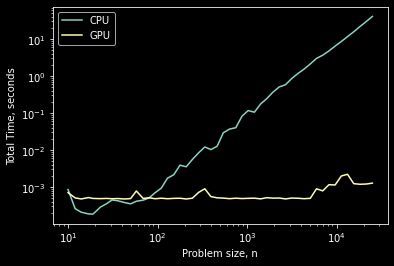

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.loglog(ns,times_cpu)
plt.loglog(ns,times_gpu)
plt.xlabel('Problem size, n')
plt.ylabel('Total Time, seconds')
plt.legend(('CPU','GPU'))

In [27]:
ratio = times_cpu/times_gpu
print(torch.median(ratio))
print(torch.max(ratio))

tensor(24.7533)
tensor(31805.9199)


From the above figure and quick analysis, we see that for these problems, the GPU is generally ~25 times as fast, getting up to $3 \cdot 10^5$ times as fast as the CPU. I did encounter an out of memory error for the GPU when I tried to look at a larger $n$.

While the above results are impressive, they may not always be realistic. Matrix vector products are much more oriented as a GPU type task, as they do not include any added logic or control flow. However, in machine learning, we add more complexity to the computational work by adding in backpropagation and other control flow features.

## Conclusion
Inspired by Alex Nets origins as one of the first deep learning models trained with GPUs, we briefly investigated the implementation and performance enhancements associated with using GPUs in PyTorch. For implementation, PyTorch does most of the heavy-lifting, and we just need to be careful about knowing whether objects are on the CPU or GPU. Additionally, there may be some setup difficulties when first trying to get PyTorch to use GPUs, like I experienced. Future biweekly reports may benefit from these implementation details, such as by using CU's Alpine supercomputer. This included a brief dive into some more low-level GPU details, such as memory and cores. In addition to learning the implementation details, we performed a quick study to compare the speed up offered by the GPU. For a matrix-vector product, we saw a massive increase for using GPUs, especially for larger problems (although for problems still small enough to be stored on the GPU's memory). Thus, we see that for future PyTorch explorations, GPUs should be used, if available. In other words, the extra implementation details for using GPUs are worth the performance increase, even for these relatively small reports!